# 컴퓨터 비전(Computer vision)
- 컴퓨터를 이용하여 이미지 또는 동영상으로 부터 의미 있는 정보를 추출하는 방법을 연구하는 학문


# image 란?
- 픽셀(pixel)이 바둑판 모양의 격자에 나열되어 있는 형태
- 픽셀은 이미지의 기본 단위 , 화소


## grayscale 이미지
- 색상 정보가 없어 오직 밝기 정보만으로 구성된 이미지


## truecolor 이미지
- 색상 정보를 가지고 있어 다양한 색상을 표현 할수 있는 이미지
- Red, Green, Blue 색 성분을 표현
- $256^3$ = 16,777,216 색상 표현 가능


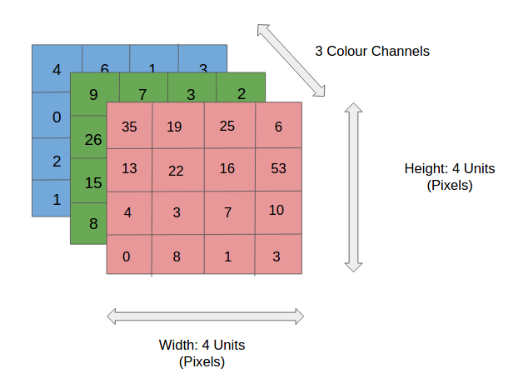

# Fully Connected Network 한계
- 3차원의 데이터인 이미지 데이터도 1차원의 데이터로 변형한 뒤 linear layer 에 입력하여 이미지 형상을 무시


# 합성곱 신경망 (Convolutional Neural Network)
- 필터(filter)를 이용하여 합성곱 연산
- 입력 데이터에 필터에 대응하는 원소끼리 곱하고, 그 합을 구한다.
- 필터(filter)
 



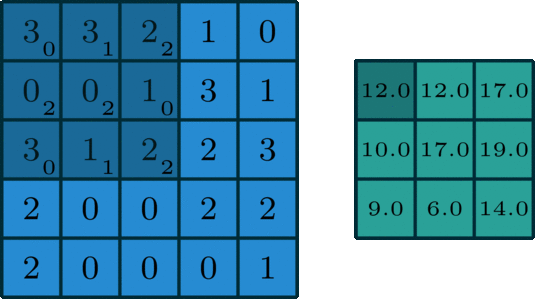

## Padding
- 합성곱 연산을 수행하기 전에 입력데이터 주변을 특정값으로 채우는 것


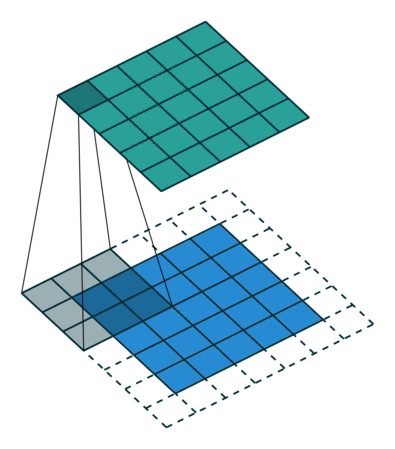

## Stride
- 필터를 적용하는 위치의 간격


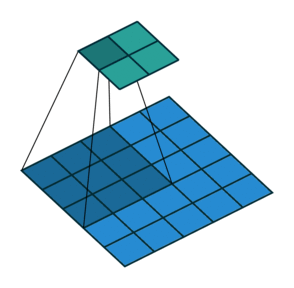

## Pooling
- 세로 및 가로 방향의 공간을 줄이는 연산
- 풀링은 일반적으로 같은 요소가 풀링연산에 재사용되지 않도록 필터 사이즈와 스트라이드 사이즈를 동일하게 한다.


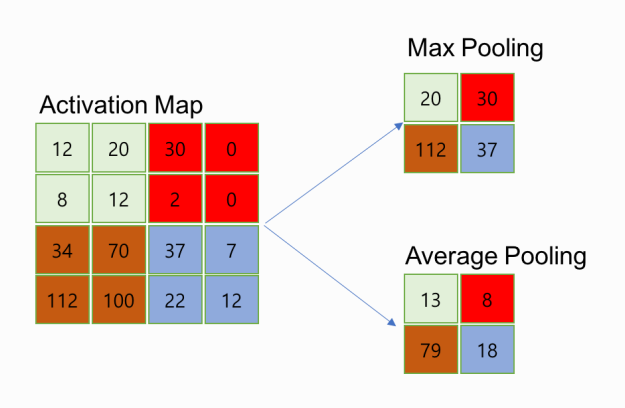

In [ ]:
import pandas as pd
import numpy as np
import torch
from tqdm.auto import tqdm
import random # 시드 고정을 위해
import os # 시드 고정을 위해

def reset_seeds(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)    # 파이썬 환경변수 시드 고정
    np.random.seed(seed)
    torch.manual_seed(seed) # cpu 연산 무작위 고정
    torch.cuda.manual_seed(seed) # gpu 연산 무작위 고정
    torch.backends.cudnn.deterministic = True  # cuda 라이브러리에서 Deterministic(결정론적)으로 예측하기 (예측에 대한 불확실성 제거 )

# 데이터 경로를 변경하시오

In [ ]:
DATA_PATH = "/content/drive/MyDrive/data/"
SEED = 42

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

- 구글 드라이브에 있는 zip 파일 세션디렉토리에 복사후 압축해제

In [ ]:
if not os.path.isdir("train"):
    !cp "{DATA_PATH}cats_and_dogs.zip" "cats_and_dogs.zip"
    !unzip -qq "cats_and_dogs.zip"

In [ ]:
from glob import glob
cats_list = sorted(glob("train/cats/*.jpg"),key= lambda x : x)
dogs_list = sorted(glob("train/dogs/*.jpg"),key= lambda x : x)
len(cats_list) , len(dogs_list) , cats_list[:5]

# 학습데이터 이미지 경로 및 정답데이터 생성

In [ ]:
img_path = cats_list + dogs_list 
labels = [0] * len(cats_list) + [1] * len(dogs_list)

len(img_path) , len(labels) , img_path[:5]

In [ ]:
sum(labels[:1000]) , sum(labels[1000:]) 

# 섞기

In [ ]:
train = np.array(img_path,dtype="object")
target = np.array(labels)

np.random.seed(SEED) 

index_list = np.arange(train.shape[0]) 
np.random.shuffle(index_list) 
np.random.shuffle(index_list) 

train = train[index_list] 
target = target[index_list] 

target[:10]

In [ ]:
train[:10]

# open cv
- 컴퓨터 비전 라이브러리 중 하나로  실시간 이미지 프로세싱에 중점을 둔 라이브러리

In [ ]:
import cv2

- 이미지 읽어오기
    - ndarray 형태로 반환
    - 이미지를 RGB 형태가 아닌 BGR 형태로 로딩

In [ ]:
train[0]

In [ ]:
img_arr = cv2.imread(train[0]) 
img_arr.shape , type(img_arr) , img_arr.dtype 

- matplot 로 이미지 보기

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img_arr)
plt.show()

- RGB 형태로 변환하기

In [ ]:
rgb_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_arr)
plt.show()

- resize

In [ ]:
resize_arr = cv2.resize(rgb_arr,(150,150))
plt.imshow(resize_arr)
plt.show()

- ndarray crop 
    - h_min:h_max , w_min:w_max

In [ ]:
plt.imshow(rgb_arr[0:100, 0:100])
plt.show()

- 중앙부분 크롭해보기

In [ ]:
h_min = rgb_arr.shape[0] // 4
w_min = rgb_arr.shape[1] // 4

plt.imshow(rgb_arr[h_min:h_min*3,w_min:w_min*3])
plt.show()

# pillow
- 이미지 분석및 처리를 쉽게 해주는 라이브러리

In [ ]:
from PIL import Image

- PIL 객체를 반환


In [ ]:
pil_image = Image.open(train[0])
type(pil_image)

In [ ]:
pil_image 

- ndarray 변환

In [ ]:
pil_image = np.array(pil_image)

In [ ]:
plt.imshow(pil_image)
plt.show()

- ndarray to pil

In [ ]:
pil_image = Image.fromarray(pil_image)
pil_image

- resize

In [ ]:
pil_image.resize([150,150])

- crop
    - (w_min,h_min ,w_max , h_max)

In [ ]:
pil_image.crop([0,0,100,100])

# 정답값

In [ ]:
target = target.reshape(-1,1) 
target.shape

# 데이터셋

In [ ]:
class CatDogDataset(torch.utils.data.Dataset):
    def __init__(self , x, y = None ): 
        self.x = x
        self.y = y
    def __len__(self): 
        return self.x.shape[0]
    def __getitem__(self, idx): 
        item = {}
        x = cv2.imread(self.x[idx]) 
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) 
        x = cv2.resize(x,(150,150)) 
        x = x / 255  
        item["x"] = torch.Tensor(x)
        if self.y is not None:
            item["y"] = torch.Tensor(self.y[idx])
        return item   

In [ ]:
dt = CatDogDataset(train,target)
dl = torch.utils.data.DataLoader(dt, batch_size = 1 , shuffle=False)
batch = next(iter(dl))
batch

# conv2d
- in_channels: input의 feature 차원
- out_channels: output의 feature 차원
- kernel_size: 필터 크기
- stride: kernel을 얼마만큼씩 이동하면서 적용할 것인가 (Default: 1)
- padding: 얼마만큼 padding할 것인가 (Default: 0)
- padding_mode: padding을 어떤 값으로 채울 것인지에 대한 설정
    - 'zeros', 'reflect', 'replicate', 'circular' (Default: 'zeros')  
- 입력 텐서 shape
    - Batch,channel, height, width

In [ ]:
x = batch["x"]
x.shape

In [ ]:
x = x.permute(0,3,1,2) 
x.shape

In [ ]:
conv2d = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)  

In [ ]:
x = conv2d(x)
x.shape 

# Pool2d
- kernel_size: 커널사이즈
- stride: 생략시 kernel_size 값을 사용

In [ ]:
avg_pool2d = torch.nn.AvgPool2d(2)
avg_pool2d(x).shape

In [ ]:
max_pool2d = torch.nn.MaxPool2d(2)
max_pool2d(x).shape

In [ ]:
adapt_avg2d = torch.nn.AdaptiveAvgPool2d(1)
adapt_avg2d(x).shape 

In [ ]:
adapt_max2d = torch.nn.AdaptiveMaxPool2d(1)
output = adapt_max2d(x)
output.shape

In [ ]:
flatten = torch.nn.Flatten() 
flatten(output).shape

# conv2d 와 pool2d 연산하는 레이어 만들기

In [ ]:
class Conv2dNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size )
        self.relu = torch.nn.ReLU()
        self.pool = torch.nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.pool(x)
        return x  

# 모델

In [ ]:
class Net(torch.nn.Module):
    def __init__(self,in_channels = 3 , out_channels = 16  ,kernel_size = 3): 
        super().__init__()

        self.seq = torch.nn.Sequential(
            Conv2dNet(in_channels, out_channels, kernel_size),
            Conv2dNet(out_channels, out_channels*2, kernel_size),
            Conv2dNet(out_channels*2, out_channels*4, kernel_size),
            Conv2dNet(out_channels*4, out_channels*8, kernel_size),
            torch.nn.AdaptiveAvgPool2d(1), 
            torch.nn.Flatten(), 
            torch.nn.Linear(out_channels*8 , 1),
        )


    def forward(self, x):
        x = x.permute(0,3,1,2)
        x  = self.seq(x)
        return x

# 모델 구조보기

In [ ]:
!pip install torchinfo

In [ ]:
import torchinfo
model = Net()
torchinfo.summary(model,(32,150,150,3))  

In [ ]:
def train_loop(dataloader,model,loss_fn,optimizer,device):
    epoch_loss = 0 
    model.train()
    for batch in dataloader: 
        pred = model(batch["x"].to(device)) 
        loss = loss_fn(pred, batch["y"].to(device))
        
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step()
        
        epoch_loss += loss.item()

    epoch_loss /= len(dataloader) 

    return epoch_loss 

In [ ]:
@torch.no_grad() 
def test_loop(dataloader,model,loss_fn,device):
    epoch_loss = 0
    model.eval() 

    pred_list = []
    sig = torch.nn.Sigmoid()

    for batch in dataloader:
        
        pred = model(batch["x"].to(device))
        if batch.get("y") is not None: 
            loss = loss_fn(pred, batch["y"].to(device))
            epoch_loss += loss.item()
        
        
        pred = sig(pred)
        pred = pred.to("cpu").numpy() 
        pred_list.append(pred)

    epoch_loss /= len(dataloader)

    pred = np.concatenate(pred_list) 
    return epoch_loss , pred 

In [ ]:
n_splits = 5
batch_size = 32 
epochs = 100
loss_fn = torch.nn.BCEWithLogitsLoss()

In [ ]:
from sklearn.model_selection import KFold
cv = KFold(n_splits=n_splits,shuffle=True, random_state=SEED)

In [ ]:
from sklearn.metrics import accuracy_score

# 학습

In [ ]:
is_holdout = True
reset_seeds(SEED)
best_score_list = []
for i,(tri,vai) in enumerate(cv.split(train)):
    
    model = Net().to(device)
    optimizer = torch.optim.Adam(model.parameters())
    
    train_dt = CatDogDataset(train[tri],target[tri])
    valid_dt = CatDogDataset(train[vai],target[vai])
    train_dl = torch.utils.data.DataLoader(train_dt, batch_size=batch_size, shuffle=True)
    valid_dl = torch.utils.data.DataLoader(valid_dt, batch_size=batch_size,shuffle=False)

    best_score = 0
    patience = 0

    for epoch in tqdm(range(epochs)):
        
        train_loss = train_loop(train_dl, model, loss_fn,optimizer,device )
        valid_loss , pred = test_loop(valid_dl, model, loss_fn,device  )
        pred = (pred > 0.5).astype(int) 
        
        score = accuracy_score(target[vai],pred )
        print(train_loss,valid_loss,score)
        patience += 1
        if best_score < score:
            patience = 0
            best_score = score
            torch.save(model.state_dict(),f"model_{i}.pth")

        if patience == 5:
            break
    print(f"Fold ({i}), BEST ACC: {best_score}")
    best_score_list.append(best_score)

    if is_holdout:
        break